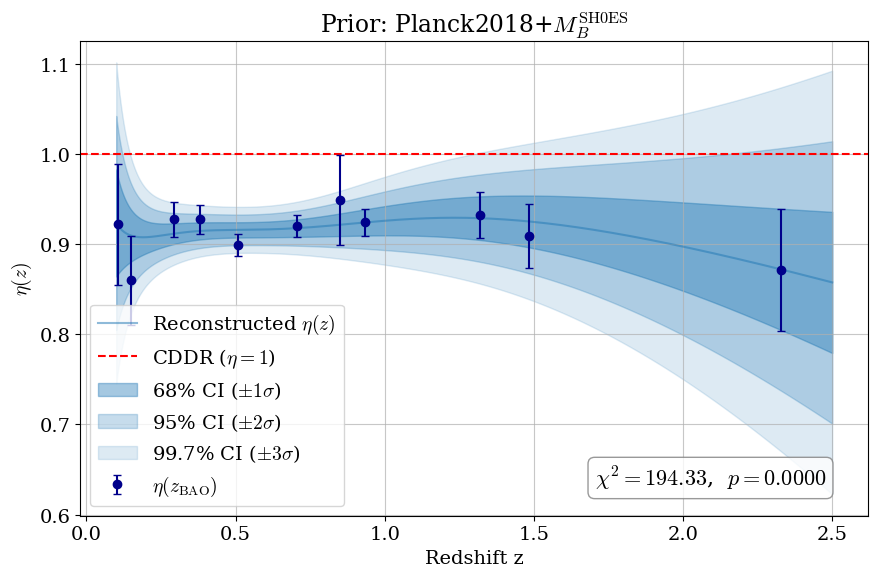

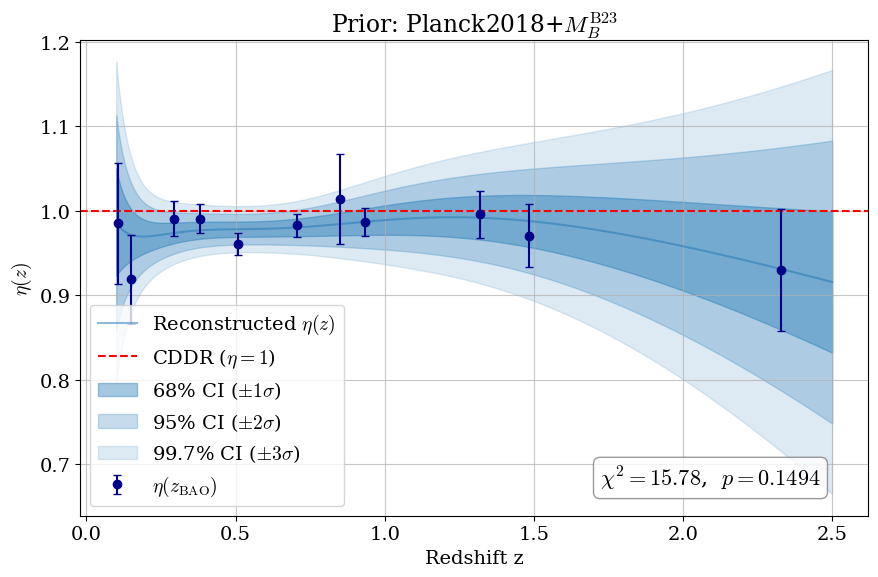

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from scipy.stats import chi2
import os

priors = [
    {"name": r"Planck2018MB0", "prior_name": r"Planck2018+$M_B^\text{SH0ES}$", "Mb": -19.253, "Mb_err": 0.027, "rd": 147.09, "rd_err": 0.26},
    {"name": r"Planck2018MB23", "prior_name": r"Planck2018+$M_B^\text{B23}$", "Mb": -19.396, "Mb_err": 0.0404, "rd": 147.09, "rd_err": 0.26},
]
c = 299792.458
z_DV_rd, DV_rd, DV_rd_err = np.loadtxt('Data/Combine_DV_rd.dat', unpack=True)
z_DM_rd, DM_rd, DM_rd_err = np.loadtxt('Data/Combine_DM_rd.dat', unpack=True)
_, H_DV, H_DV_err = np.loadtxt('Data/Hz_DVreconstruct_results.txt', unpack=True)
data = pd.read_csv('Data/Pantheon+SH0ES.dat', sep=' ')
z_sn = data['zHD'].values
mb = data['m_b_corr'].values
mb_err = data['m_b_corr_err_DIAG'].values

os.makedirs('fig', exist_ok=True)

kernel = C(1.0, (1e-3, 1e10)) * Matern(length_scale=0.1, length_scale_bounds=(1e-2, 1e3), nu=5/2)

plt.rcParams.update({
    'font.family': 'serif',
    'mathtext.fontset': 'cm',
    'font.size': 14
})

for prior in priors:
    Mb = prior["Mb"]
    Mb_err = prior["Mb_err"]
    rd = prior["rd"]
    rd_err = prior["rd_err"]
    prior_name = prior["prior_name"]
    name = prior["name"]

    DA_rd = DV_rd**(3/2) * rd**(1/2) * H_DV**(1/2) / (c**(1/2) * z_DV_rd**(1/2) * (1 + z_DV_rd))
    DA_rd_err = DA_rd * np.sqrt((1.5 / DV_rd * DV_rd_err)**2 + (0.5 / rd * rd_err)**2 + (0.5 / H_DV * H_DV_err)**2)
    DA_DV = DA_rd * rd
    DA_DV_err = DA_DV * np.sqrt((DA_rd_err / DA_rd)**2 + (rd_err / rd)**2)
    DL_DV = DA_DV * (1 + z_DV_rd)**2
    DL_DV_err = DA_DV_err * (1 + z_DV_rd)**2

    DA_rd_DM = DM_rd / (1 + z_DM_rd)
    DA_rd_err_DM = DM_rd_err / (1 + z_DM_rd)
    DA_DM = DA_rd_DM * rd
    DA_desi_err = DA_DM * np.sqrt((DA_rd_err_DM / DA_rd_DM)**2 + (rd_err / rd)**2)
    DL_DM = DA_DM * (1 + z_DM_rd)**2
    DL_DM_err = DA_desi_err * (1 + z_DM_rd)**2

    z_bao = np.concatenate((z_DV_rd, z_DM_rd))
    DL_bao = np.concatenate((DL_DV, DL_DM))
    DL_bao_err = np.concatenate((DL_DV_err, DL_DM_err))

    gpr_desi = GaussianProcessRegressor(kernel=kernel, alpha=DL_bao_err**2, n_restarts_optimizer=10)
    gpr_desi.fit(z_bao.reshape(-1, 1), DL_bao)
    z_bao_pred = np.linspace(0, 2.5, 1000).reshape(-1, 1)
    DL_bao_pred, DL_bao_pred_err = gpr_desi.predict(z_bao_pred, return_std=True)

    mu_sn = mb - Mb
    mu_sn_err = np.sqrt(mb_err**2 + Mb_err**2)
    DL_sn = 10 ** ((mu_sn - 25) / 5)
    DL_sn_err = np.log(10) / 5 * mu_sn_err * DL_sn

    gpr = GaussianProcessRegressor(kernel=kernel, alpha=DL_sn_err**2, n_restarts_optimizer=5)
    gpr.fit(z_sn.reshape(-1, 1), DL_sn)
    z_pred = np.linspace(0, 2.5, 1000).reshape(-1, 1)
    DL_pred, DL_std = gpr.predict(z_pred, return_std=True)
    DL_sn_match, DL_sn_match_err = gpr.predict(z_bao.reshape(-1, 1), return_std=True)

    eta = DL_sn_match / DL_bao
    eta_err = abs(eta) * np.sqrt((DL_sn_match_err / DL_sn_match)**2 + (DL_bao_err / DL_bao)**2)
    eta_recon = DL_pred / DL_bao_pred
    eta_recon_err = abs(eta_recon) * np.sqrt((DL_std / DL_pred)**2 + (DL_bao_pred_err / DL_bao_pred)**2)

    chi2_value = np.sum((eta - 1)**2 / eta_err**2)
    p_value = 1 - chi2.cdf(chi2_value, df=len(z_bao))

    plt.figure(figsize=(9, 6))
    z_pred = z_pred.flatten()
    plt.plot(z_pred[z_pred > 0.1], eta_recon[z_pred > 0.1], alpha=0.5, label=r'Reconstructed $\eta(z)$')
    plt.axhline(y=1, color='red', linestyle='--', label=r'CDDR ($\eta=1$)')
    plt.errorbar(z_bao, eta, yerr=eta_err, fmt='o', label=r'$\eta(z_\text{BAO})$', color='darkblue', capsize=3)

    for sigma, alpha, label in zip([1, 2, 3], [0.4, 0.25, 0.15],
                                   [r'68% CI ($\pm 1\sigma$)', r'95% CI ($\pm 2\sigma$)', r'99.7% CI ($\pm 3\sigma$)']):
        plt.fill_between(z_pred[z_pred > 0.1],
                        (eta_recon - sigma * eta_recon_err)[z_pred > 0.1],
                        (eta_recon + sigma * eta_recon_err)[z_pred > 0.1],
                        color='#1f77b4', alpha=alpha, label=label)

    plt.text(0.8, 0.05, r'$\chi^2 = %.2f$,  $p = %.4f$' % (chi2_value, p_value),
             fontsize=16, ha='center', va='bottom', transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.8))


    plt.xlabel('Redshift z')
    plt.ylabel(r'$\eta(z)$')
    plt.title(f'Prior: {prior_name}')
    plt.legend(fontsize=14, frameon=True, loc='lower left', prop={'family': 'serif'})
    plt.grid(True, alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"fig/eta_reconstruct_{name}.pdf", bbox_inches='tight')
    plt.show()

Starting m_b reconstruction with MCMC


100%|██████████| 2000/2000 [03:02<00:00, 10.94it/s]


m_b reconstruction MCMC finished.

Processing prior: eta_reconstruct_CPI_Planck2018MB0


/home/wzx/miniconda3/envs/null_test/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:523: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


χ² = 124.65, p-value = 0.0000


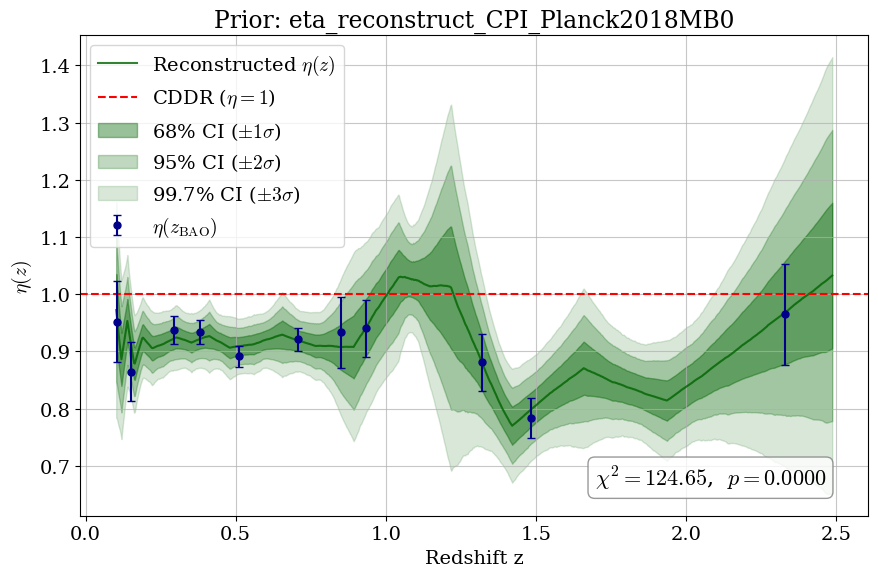


Processing prior: Planck2018+$M_B^\text{B23}$


/home/wzx/miniconda3/envs/null_test/lib/python3.13/site-packages/sklearn/gaussian_process/_gpr.py:523: RuntimeWarning: covariance is not symmetric positive-semidefinite.
  y_samples = rng.multivariate_normal(y_mean, y_cov, n_samples).T


χ² = 26.60, p-value = 0.0053


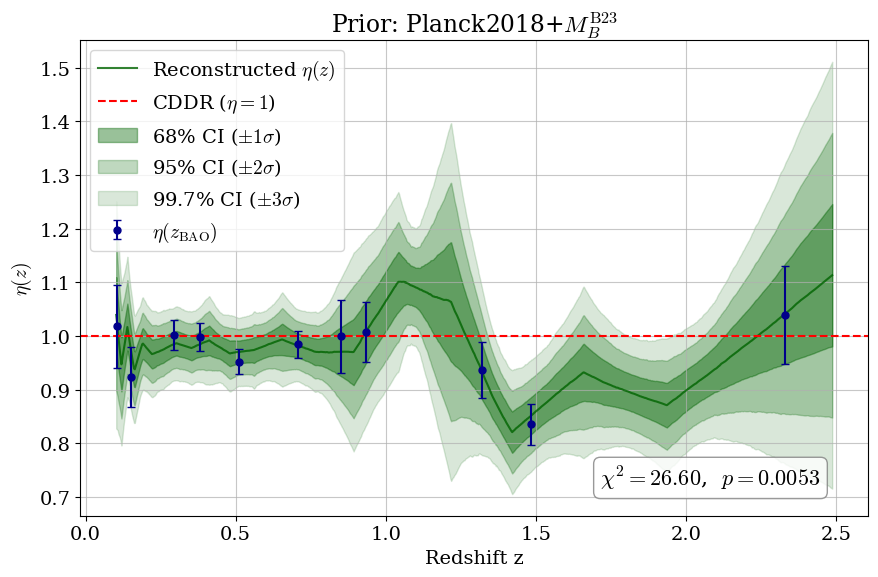


All priors processed.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import Matern, ConstantKernel as C
from scipy.stats import chi2
from scipy.interpolate import interp1d
import emcee
import os


priors = [
    {"name":r"Planck2018MB0","prior_name": r"Planck2018+$M_B^\text{SH0ES}$", "Mb": -19.253, "Mb_err": 0.027, "rd": 147.09, "rd_err": 0.26},
    {"name":r"Planck2018MB23","prior_name": r"Planck2018+$M_B^\text{B23}$", "Mb": -19.396, "Mb_err": 0.0404, "rd": 147.09, "rd_err": 0.26},
]


c = 299792.458 # km/s
z_DV_rd, DV_rd, DV_rd_err = np.loadtxt('Data/Combine_DV_rd.dat', unpack=True)
z_DM_rd, DM_rd, DM_rd_err = np.loadtxt('Data/Combine_DM_rd.dat', unpack=True) 
_, H_DV, H_DV_err = np.loadtxt('Data/Hz_DVreconstruct_results.txt', unpack=True)
data = pd.read_csv('Data/Pantheon+SH0ES.dat', sep=' ')
z_sn = data['zHD'].values
mb = data['m_b_corr'].values
mb_err = data['m_b_corr_err_DIAG'].values


os.makedirs('fig', exist_ok=True)


try:
    with open('Data/Pantheon+SH0ES_STAT+SYS.cov', 'r') as f:
        lines = f.readlines()
    N = int(lines[0].strip())
    cov_elements = np.array([float(x.strip()) for x in lines[1:]])
    cov_full = cov_elements.reshape((N, N))
    cov_inv = np.linalg.inv(cov_full)
except FileNotFoundError:
    cov_stat = np.diag(mb_err**2)
    cov_inv = np.linalg.inv(cov_stat)
    print("Warning: Using diagonal errors only for Pantheon+SH0ES.cov.")


print("Starting m_b reconstruction with MCMC")


z_b = np.logspace(np.log10(0.01), np.log10(max(z_sn)), 36) 
ln_z_b = np.log(z_b)


def compute_mB_bar(z, mB_b_values, z_b_points):
    ln_z = np.log(z)
    interp_func = interp1d(np.log(z_b_points), mB_b_values, kind='linear', fill_value="extrapolate")
    return interp_func(ln_z)


def ln_likelihood(mB_b_params, z_data, mB_data, cov_inv_matrix):
    mB_bar = compute_mB_bar(z_data, mB_b_params, z_b)
    delta = mB_data - mB_bar
    chi2 = delta.T @ cov_inv_matrix @ delta
    return -0.5 * chi2

def ln_prior(mB_b_params):
    if np.all((10 < mB_b_params) & (mB_b_params < 30)): 
        return 0.0
    return -np.inf


def ln_posterior(mB_b_params, z_data, mB_data, cov_inv_matrix):
    lp = ln_prior(mB_b_params)
    if not np.isfinite(lp):
        return -np.inf
    return lp + ln_likelihood(mB_b_params, z_data, mB_data, cov_inv_matrix)


n_walkers = 72
n_dim = len(z_b)
mB_b_init = np.interp(z_b, z_sn, mb) 
np.random.seed(42)
initial = mB_b_init + 0.1 * np.random.randn(n_walkers, n_dim) 


sampler = emcee.EnsembleSampler(n_walkers, n_dim, ln_posterior, args=(z_sn, mb, cov_inv))
sampler.run_mcmc(initial, 2000, progress=True) 
print("m_b reconstruction MCMC finished.")


mB_b_samples = sampler.get_chain(discard=200, flat=True) 
mB_b_opt = np.median(mB_b_samples, axis=0) 


z_plot = np.linspace(0.01, max(z_sn) * 1.1, 1000).reshape(-1, 1) 


kernel = C(1.0, (1e-3, 1e10)) * Matern(length_scale=0.1, length_scale_bounds=(1e-2, 1e3), nu=5/2)


for prior in priors:
    Mb = prior["Mb"]
    Mb_err = prior["Mb_err"]
    rd = prior["rd"]
    rd_err = prior["rd_err"]
    prior_name = prior["prior_name"]
    name = prior["name"]
    print(f"\nProcessing prior: {prior_name}")

    DA_rd_DV = DV_rd**(3/2) * rd**(1/2) * H_DV**(1/2) / (c**(1/2) * z_DV_rd**(1/2) * (1 + z_DV_rd))
    DA_rd_err_DV = DA_rd_DV * np.sqrt((1.5 / DV_rd * DV_rd_err)**2 + (0.5 / rd * rd_err)**2 + (0.5 / H_DV * H_DV_err)**2)
    DA_DV = DA_rd_DV * rd
    DA_DV_err = DA_DV * np.sqrt((DA_rd_err_DV / DA_rd_DV)**2 + (rd_err / rd)**2)
    DL_DV = DA_DV * (1 + z_DV_rd)**2
    DL_DV_err = DA_DV_err * (1 + z_DV_rd)**2

    DA_rd_DM = DM_rd / (1 + z_DM_rd)
    DA_rd_err_DM = DM_rd_err / (1 + z_DM_rd)
    DA_DM = DA_rd_DM * rd
    DA_DM_err = DA_DM * np.sqrt((DA_rd_err_DM / DA_rd_DM)**2 + (rd_err / rd)**2)
    DL_DM = DA_DM * (1 + z_DM_rd)**2
    DL_DM_err = DA_DM_err * (1 + z_DM_rd)**2

    z_bao = np.concatenate((z_DV_rd, z_DM_rd))
    DL_bao = np.concatenate((DL_DV, DL_DM))
    DL_bao_err = np.concatenate((DL_DV_err, DL_DM_err))

    gpr_desi = GaussianProcessRegressor(kernel=kernel, alpha=DL_bao_err**2, n_restarts_optimizer=10)
    gpr_desi.fit(z_bao.reshape(-1, 1), DL_bao)

    DL_bao_pred, DL_bao_pred_std = gpr_desi.predict(z_plot, return_std=True)

    n_plot_samples = 1000
    random_mB_b_indices = np.random.choice(len(mB_b_samples), n_plot_samples, replace=False)
    Mb_samples_for_DL = np.random.normal(Mb, Mb_err, n_plot_samples)

    DL_sn_plot_samples = []
    for i in range(n_plot_samples):
        mB_b_sample = mB_b_samples[random_mB_b_indices[i]]
        Mb_sample = Mb_samples_for_DL[i] # 每次抽取一个Mb样本

        mB_bar_plot_sample = compute_mB_bar(z_plot.flatten(), mB_b_sample, z_b)

        mu_sn_plot_sample = mB_bar_plot_sample - Mb_sample
        DL_sn_plot_sample = 10 ** ((mu_sn_plot_sample - 25) / 5)
        DL_sn_plot_samples.append(DL_sn_plot_sample)

    DL_sn_plot_samples = np.array(DL_sn_plot_samples)

    DL_sn_pred = np.median(DL_sn_plot_samples, axis=0)
    DL_sn_pred_lower = np.percentile(DL_sn_plot_samples, 16, axis=0)
    DL_sn_pred_upper = np.percentile(DL_sn_plot_samples, 84, axis=0)
    # DL_sn_pred_std = (DL_sn_pred_upper - DL_sn_pred_lower) / 2 # 近似标准差

    # eta reconstruction
    eta_recon = DL_sn_pred / DL_bao_pred.flatten()

    DL_bao_pred_samples = gpr_desi.sample_y(z_plot, n_samples=n_plot_samples).T

    eta_recon_samples = DL_sn_plot_samples / DL_bao_pred_samples

    eta_recon_lower = np.percentile(eta_recon_samples, 16, axis=0)
    eta_recon_upper = np.percentile(eta_recon_samples, 84, axis=0)
    eta_recon_err = (eta_recon_upper - eta_recon_lower) / 2 # 近似标准差

    mB_bar_sn_match_samples = []
    Mb_samples_for_chi2 = np.random.normal(Mb, Mb_err, n_plot_samples) # 重新抽取Mb样本

    for i in range(n_plot_samples):
        mB_b_sample = mB_b_samples[random_mB_b_indices[i]] # 使用之前抽取的mB_b_samples索引
        Mb_sample = Mb_samples_for_chi2[i]
        mB_bar_at_bao_z_sample = compute_mB_bar(z_bao, mB_b_sample, z_b)
        mu_sn_at_bao_z_sample = mB_bar_at_bao_z_sample - Mb_sample
        DL_sn_at_bao_z_sample = 10 ** ((mu_sn_at_bao_z_sample - 25) / 5)
        mB_bar_sn_match_samples.append(DL_sn_at_bao_z_sample)

    mB_bar_sn_match_samples = np.array(mB_bar_sn_match_samples)
    DL_sn_match = np.median(mB_bar_sn_match_samples, axis=0)
    DL_sn_match_lower = np.percentile(mB_bar_sn_match_samples, 16, axis=0)
    DL_sn_match_upper = np.percentile(mB_bar_sn_match_samples, 84, axis=0)
    DL_sn_match_err = (DL_sn_match_upper - DL_sn_match_lower) / 2

    eta = DL_sn_match / DL_bao
    eta_err = abs(eta) * np.sqrt((DL_sn_match_err / DL_sn_match)**2 + (DL_bao_err / DL_bao)**2)

    chi2_value = np.sum((eta - 1)**2 / eta_err**2)
    p_value = 1 - chi2.cdf(chi2_value, df=len(z_bao))
    print(f"χ² = {chi2_value:.2f}, p-value = {p_value:.4f}")

    plt.rcParams.update({
        'font.family': 'serif',
        'mathtext.fontset': 'cm',
        'font.size': 14
    })

    fig, ax = plt.subplots(figsize=(9, 6))

    z_plot_flat = z_plot.flatten()
    plot_mask = z_plot_flat > 0.1
    plt.plot(z_plot_flat[plot_mask], eta_recon[plot_mask],
             alpha=0.8, color='darkgreen', label=r'Reconstructed $\eta(z)$')
    plt.axhline(y=1, color='red', linestyle='--', label=r'CDDR ($\eta=1$)')

    for sigma, alpha_fill, label_fill in zip([1, 2, 3], [0.4, 0.25, 0.15],
                                           [r'68% CI ($\pm 1\sigma$)',
                                            r'95% CI ($\pm 2\sigma$)',
                                            r'99.7% CI ($\pm 3\sigma$)']):
        plt.fill_between(z_plot_flat[plot_mask],
                        (eta_recon - sigma * eta_recon_err)[plot_mask],
                        (eta_recon + sigma * eta_recon_err)[plot_mask],
                        color='darkgreen', alpha=alpha_fill, label=label_fill)

    plt.errorbar(z_bao, eta, yerr=eta_err, fmt='o', label=r'$\eta(z_\text{BAO})$',
                 color='darkblue', capsize=3, markersize=5)

    plt.text(0.8, 0.05,
             r'$\chi^2 = %.2f$,  $p = %.4f$' % (chi2_value, p_value),
             fontsize=16, ha='center', va='bottom',
             transform=plt.gca().transAxes,
             bbox=dict(boxstyle='round', facecolor='white', edgecolor='gray', alpha=0.8))

    plt.xlabel('Redshift z')
    plt.ylabel(r'$\eta(z)$')
    plt.title(f'Prior: {prior_name}')
    plt.legend(fontsize=16, frameon=True, loc='best', prop={'family': 'serif'})
    plt.grid(True, alpha=0.7)
    plt.tight_layout()
    plt.savefig(f"fig/eta_reconstruct_CPI_{name}.pdf", bbox_inches='tight')
    plt.show()

print("\nAll priors processed.")
